# Week 16 - Day 1: Reinforcement Learning Fundamentals for Trading

## Learning Objectives
- Understand the Markov Decision Process (MDP) framework
- Define agents, environments, states, actions, and rewards in trading context
- Formulate trading as a reinforcement learning problem
- Build a simple trading environment from scratch

---

## Why Reinforcement Learning for Trading?

Traditional ML approaches treat trading as a supervised learning problem (predict price direction). However, trading is inherently a **sequential decision-making** problem where:

- Actions affect future states (positions affect risk exposure)
- Delayed rewards (profit/loss realized at exit, not entry)
- Exploration vs exploitation tradeoff (try new strategies vs stick with what works)

RL naturally handles these characteristics!

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from typing import Tuple, List, Dict, Optional
from dataclasses import dataclass
from enum import Enum
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")

PyTorch version: 2.9.1
NumPy version: 2.4.1


---

## 1. Markov Decision Process (MDP) Framework

### 1.1 What is an MDP?

A Markov Decision Process is defined by the tuple $(S, A, P, R, \gamma)$:

| Component | Symbol | Description |
|-----------|--------|-------------|
| **State Space** | $S$ | Set of all possible states |
| **Action Space** | $A$ | Set of all possible actions |
| **Transition Probability** | $P(s'|s,a)$ | Probability of reaching state $s'$ from state $s$ after action $a$ |
| **Reward Function** | $R(s,a,s')$ | Immediate reward for transition |
| **Discount Factor** | $\gamma \in [0,1]$ | How much to value future vs immediate rewards |

### 1.2 The Markov Property

$$P(s_{t+1} | s_t, a_t, s_{t-1}, a_{t-1}, ..., s_0, a_0) = P(s_{t+1} | s_t, a_t)$$

The future depends only on the **current state**, not the history of how we got there.

**Trading Implication**: We need to encode all relevant information in the state (price history, position, indicators, etc.)

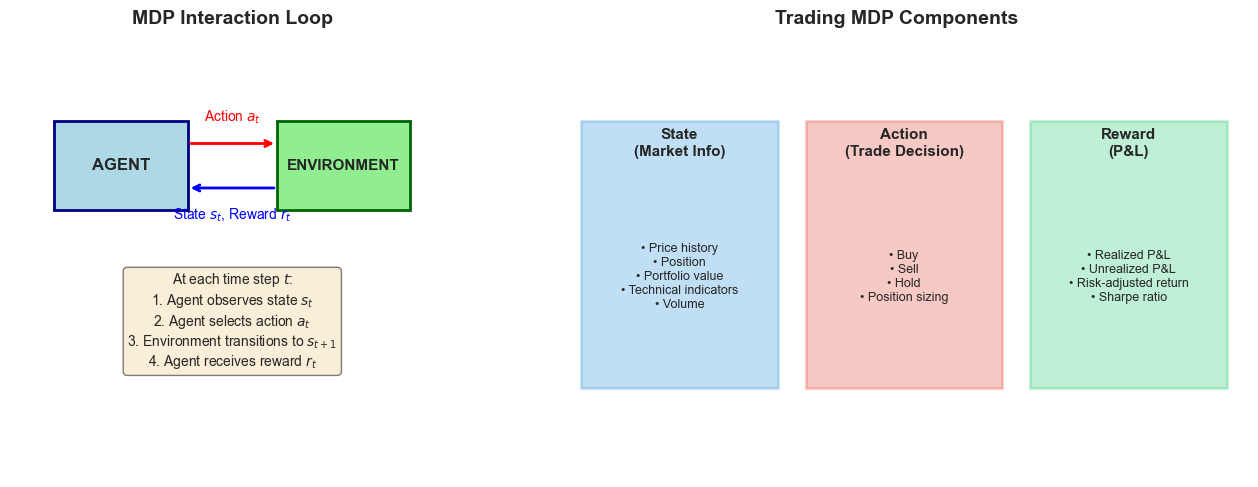

In [2]:
# Visualize MDP Components

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: MDP Interaction Loop
ax1 = axes[0]
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_title('MDP Interaction Loop', fontsize=14, fontweight='bold')

# Agent box
agent_box = plt.Rectangle((1, 6), 3, 2, fill=True, facecolor='lightblue', edgecolor='navy', linewidth=2)
ax1.add_patch(agent_box)
ax1.text(2.5, 7, 'AGENT', ha='center', va='center', fontsize=12, fontweight='bold')

# Environment box
env_box = plt.Rectangle((6, 6), 3, 2, fill=True, facecolor='lightgreen', edgecolor='darkgreen', linewidth=2)
ax1.add_patch(env_box)
ax1.text(7.5, 7, 'ENVIRONMENT', ha='center', va='center', fontsize=11, fontweight='bold')

# Arrows
ax1.annotate('', xy=(6, 7.5), xytext=(4, 7.5),
            arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax1.text(5, 8, 'Action $a_t$', ha='center', fontsize=10, color='red')

ax1.annotate('', xy=(4, 6.5), xytext=(6, 6.5),
            arrowprops=dict(arrowstyle='->', color='blue', lw=2))
ax1.text(5, 5.8, 'State $s_t$, Reward $r_t$', ha='center', fontsize=10, color='blue')

# Time step indicator
ax1.text(5, 3.5, 'At each time step $t$:\n1. Agent observes state $s_t$\n2. Agent selects action $a_t$\n3. Environment transitions to $s_{t+1}$\n4. Agent receives reward $r_t$',
        ha='center', va='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Right plot: Trading-specific MDP
ax2 = axes[1]
categories = ['State\n(Market Info)', 'Action\n(Trade Decision)', 'Reward\n(P&L)']
examples = [
    '• Price history\n• Position\n• Portfolio value\n• Technical indicators\n• Volume',
    '• Buy\n• Sell\n• Hold\n• Position sizing',
    '• Realized P&L\n• Unrealized P&L\n• Risk-adjusted return\n• Sharpe ratio'
]
colors = ['#3498db', '#e74c3c', '#2ecc71']

for i, (cat, ex, col) in enumerate(zip(categories, examples, colors)):
    rect = plt.Rectangle((i*3.2 + 0.5, 2), 2.8, 6, fill=True, facecolor=col, alpha=0.3, edgecolor=col, linewidth=2)
    ax2.add_patch(rect)
    ax2.text(i*3.2 + 1.9, 7.5, cat, ha='center', va='center', fontsize=11, fontweight='bold')
    ax2.text(i*3.2 + 1.9, 4.5, ex, ha='center', va='center', fontsize=9)

ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)
ax2.axis('off')
ax2.set_title('Trading MDP Components', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

---

## 2. Trading RL Components: Detailed Definitions

### 2.1 The Agent
The **agent** is the trading algorithm/model that:
- Observes market states
- Makes trading decisions based on a policy $\pi(a|s)$
- Learns from rewards to improve the policy

### 2.2 The Environment
The **environment** represents the market and includes:
- Price dynamics (historical or simulated)
- Order execution mechanics
- Transaction costs
- Slippage modeling

### 2.3 State Space Design
Critical design choice! States should capture:
- **Market features**: OHLCV, returns, volatility, momentum
- **Agent features**: Current position, P&L, time in trade
- **Technical indicators**: RSI, MACD, Bollinger Bands

In [3]:
# Define Trading Actions

class TradingAction(Enum):
    """Discrete trading actions"""
    SELL = -1      # Go short or reduce long position
    HOLD = 0       # Do nothing
    BUY = 1        # Go long or reduce short position


@dataclass
class TradingState:
    """State representation for trading"""
    # Market features
    price: float                    # Current price
    returns: np.ndarray            # Recent returns (lookback window)
    volatility: float              # Recent volatility
    
    # Agent features
    position: int                   # Current position (-1, 0, 1)
    entry_price: Optional[float]   # Price at which position was entered
    unrealized_pnl: float          # Current unrealized P&L
    
    def to_tensor(self) -> torch.Tensor:
        """Convert state to tensor for neural network input"""
        features = [
            self.price / 100,  # Normalize price
            *self.returns,
            self.volatility,
            self.position,
            self.unrealized_pnl
        ]
        return torch.tensor(features, dtype=torch.float32)


# Example state
example_state = TradingState(
    price=100.5,
    returns=np.array([0.01, -0.005, 0.02, 0.003, -0.01]),
    volatility=0.02,
    position=1,
    entry_price=99.0,
    unrealized_pnl=1.5
)

print("Example Trading State:")
print(f"  Price: ${example_state.price:.2f}")
print(f"  Recent Returns: {example_state.returns}")
print(f"  Volatility: {example_state.volatility:.2%}")
print(f"  Position: {example_state.position} (Long)")
print(f"  Entry Price: ${example_state.entry_price:.2f}")
print(f"  Unrealized P&L: ${example_state.unrealized_pnl:.2f}")
print(f"\nState Tensor: {example_state.to_tensor()}")
print(f"Tensor Shape: {example_state.to_tensor().shape}")

Example Trading State:
  Price: $100.50
  Recent Returns: [ 0.01  -0.005  0.02   0.003 -0.01 ]
  Volatility: 2.00%
  Position: 1 (Long)
  Entry Price: $99.00
  Unrealized P&L: $1.50

State Tensor: tensor([ 1.0050,  0.0100, -0.0050,  0.0200,  0.0030, -0.0100,  0.0200,  1.0000,
         1.5000])
Tensor Shape: torch.Size([9])


### 2.4 Reward Function Design

The reward function is **crucial** - it defines what behavior we want to learn!

| Reward Type | Formula | Pros | Cons |
|-------------|---------|------|------|
| **Simple P&L** | $r_t = p_t - p_{t-1}$ | Simple, direct | Ignores risk |
| **Log Return** | $r_t = \log(p_t / p_{t-1})$ | Time-additive | Still ignores risk |
| **Risk-Adjusted** | $r_t = \frac{\text{return}}{\text{volatility}}$ | Considers risk | Complex to compute |
| **Differential Sharpe** | $r_t = \frac{\partial SR}{\partial \theta}$ | Directly optimizes Sharpe | Requires careful tuning |

In [4]:
# Different Reward Function Implementations

class RewardFunction:
    """Different reward function implementations for trading RL"""
    
    @staticmethod
    def simple_pnl(position: int, price_change: float, 
                   transaction_cost: float = 0.001) -> float:
        """Simple P&L reward with transaction costs"""
        return position * price_change - abs(transaction_cost)
    
    @staticmethod
    def log_return(position: int, current_price: float, 
                   previous_price: float) -> float:
        """Log return reward"""
        log_ret = np.log(current_price / previous_price)
        return position * log_ret
    
    @staticmethod
    def risk_adjusted(returns: np.ndarray, position: int, 
                      price_change: float, risk_aversion: float = 1.0) -> float:
        """Risk-adjusted reward: return - risk_aversion * variance"""
        raw_return = position * price_change
        variance = np.var(returns) if len(returns) > 1 else 0
        return raw_return - risk_aversion * variance
    
    @staticmethod
    def differential_sharpe(returns_history: List[float], 
                           current_return: float,
                           eta: float = 0.01) -> float:
        """
        Differential Sharpe Ratio (Moody & Saffell, 2001)
        Incrementally updates Sharpe ratio approximation
        """
        if len(returns_history) < 2:
            return current_return
        
        A = np.mean(returns_history)  # Running mean
        B = np.mean(np.array(returns_history)**2)  # Running second moment
        
        # Differential Sharpe approximation
        delta_A = current_return - A
        delta_B = current_return**2 - B
        
        denominator = (B - A**2)**(3/2)
        if denominator < 1e-8:
            return current_return
        
        dsr = (B * delta_A - 0.5 * A * delta_B) / denominator
        return dsr


# Demonstrate different reward functions
print("Reward Function Comparison:")
print("=" * 50)

# Scenario: Long position, price went up by $1
position = 1
price_change = 1.0
current_price = 101.0
previous_price = 100.0
recent_returns = np.array([0.01, -0.005, 0.02, 0.003, -0.01])

print(f"\nScenario: Long position, price {previous_price} -> {current_price}")
print(f"\n1. Simple P&L Reward: {RewardFunction.simple_pnl(position, price_change):.4f}")
print(f"2. Log Return Reward: {RewardFunction.log_return(position, current_price, previous_price):.4f}")
print(f"3. Risk-Adjusted Reward: {RewardFunction.risk_adjusted(recent_returns, position, price_change):.4f}")
print(f"4. Differential Sharpe: {RewardFunction.differential_sharpe(list(recent_returns), price_change/previous_price):.4f}")

Reward Function Comparison:

Scenario: Long position, price 100.0 -> 101.0

1. Simple P&L Reward: 0.9990
2. Log Return Reward: 0.0100
3. Risk-Adjusted Reward: 0.9999
4. Differential Sharpe: 0.7078


---

## 3. Trading as an RL Problem: Formal Formulation

### 3.1 The Objective

Find an optimal policy $\pi^*$ that maximizes expected cumulative reward:

$$\pi^* = \arg\max_\pi \mathbb{E}\left[\sum_{t=0}^{T} \gamma^t R(s_t, a_t, s_{t+1}) \right]$$

### 3.2 Value Functions

**State-Value Function** $V^\pi(s)$: Expected return starting from state $s$, following policy $\pi$

$$V^\pi(s) = \mathbb{E}_\pi\left[\sum_{k=0}^{\infty} \gamma^k r_{t+k+1} | s_t = s\right]$$

**Action-Value Function** $Q^\pi(s, a)$: Expected return starting from state $s$, taking action $a$, then following policy $\pi$

$$Q^\pi(s, a) = \mathbb{E}_\pi\left[\sum_{k=0}^{\infty} \gamma^k r_{t+k+1} | s_t = s, a_t = a\right]$$

### 3.3 Bellman Equations

The **Bellman Optimality Equation** for Q-values:

$$Q^*(s, a) = \mathbb{E}\left[r + \gamma \max_{a'} Q^*(s', a')\right]$$

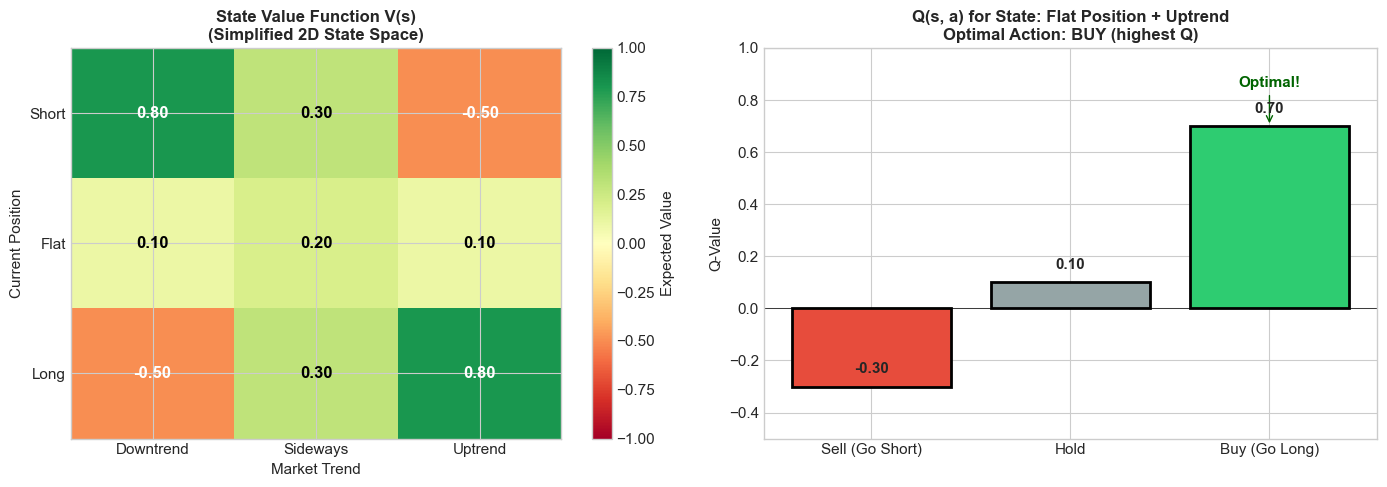

In [5]:
# Visualize Value Function Concept for Trading

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Simple state-value visualization
ax1 = axes[0]

# Create a grid of states (position x price_trend)
positions = ['Short', 'Flat', 'Long']
trends = ['Downtrend', 'Sideways', 'Uptrend']

# Hypothetical Q-values for each state-action pair
# Higher value = better state to be in
state_values = np.array([
    [0.8, 0.3, -0.5],   # Short position: good in downtrend, bad in uptrend
    [0.1, 0.2, 0.1],    # Flat: neutral
    [-0.5, 0.3, 0.8]    # Long: bad in downtrend, good in uptrend
])

im = ax1.imshow(state_values, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
ax1.set_xticks(range(3))
ax1.set_xticklabels(trends)
ax1.set_yticks(range(3))
ax1.set_yticklabels(positions)
ax1.set_xlabel('Market Trend', fontsize=11)
ax1.set_ylabel('Current Position', fontsize=11)
ax1.set_title('State Value Function V(s)\n(Simplified 2D State Space)', fontsize=12, fontweight='bold')

# Add value annotations
for i in range(3):
    for j in range(3):
        ax1.text(j, i, f'{state_values[i, j]:.2f}', ha='center', va='center', 
                fontsize=12, fontweight='bold',
                color='white' if abs(state_values[i, j]) > 0.4 else 'black')

plt.colorbar(im, ax=ax1, label='Expected Value')

# Right: Q-values for actions in a given state
ax2 = axes[1]

# Q-values for different actions when in 'Flat position, Uptrend detected'
actions = ['Sell (Go Short)', 'Hold', 'Buy (Go Long)']
q_values = [-0.3, 0.1, 0.7]
colors = ['#e74c3c', '#95a5a6', '#2ecc71']

bars = ax2.bar(actions, q_values, color=colors, edgecolor='black', linewidth=2)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('Q-Value', fontsize=11)
ax2.set_title('Q(s, a) for State: Flat Position + Uptrend\nOptimal Action: BUY (highest Q)', 
              fontsize=12, fontweight='bold')
ax2.set_ylim(-0.5, 1.0)

# Highlight optimal action
ax2.annotate('Optimal!', xy=(2, 0.7), xytext=(2, 0.85),
            fontsize=11, ha='center', fontweight='bold', color='darkgreen',
            arrowprops=dict(arrowstyle='->', color='darkgreen'))

for bar, val in zip(bars, q_values):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.05, f'{val:.2f}', 
            ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

---

## 4. Building a Simple Trading Environment

Let's build a trading environment following the **OpenAI Gym** interface pattern:

```python
env.reset()      # Initialize environment, return initial state
env.step(action) # Take action, return (next_state, reward, done, info)
```

In [6]:
class SimpleTradingEnvironment:
    """
    A simple trading environment for learning RL concepts.
    
    Features:
    - Single asset trading
    - Discrete actions: Buy, Hold, Sell
    - Position tracking: -1 (short), 0 (flat), 1 (long)
    - Transaction costs
    - P&L tracking
    """
    
    def __init__(self, 
                 prices: np.ndarray,
                 initial_balance: float = 10000.0,
                 transaction_cost: float = 0.001,  # 0.1% per trade
                 lookback_window: int = 10):
        """
        Initialize the trading environment.
        
        Args:
            prices: Array of historical prices
            initial_balance: Starting capital
            transaction_cost: Cost per trade (as fraction)
            lookback_window: Number of past returns to include in state
        """
        self.prices = prices
        self.initial_balance = initial_balance
        self.transaction_cost = transaction_cost
        self.lookback_window = lookback_window
        
        # Calculate returns
        self.returns = np.diff(prices) / prices[:-1]
        
        # State dimensions
        self.state_dim = lookback_window + 3  # returns + position + unrealized_pnl + volatility
        self.action_dim = 3  # Sell, Hold, Buy
        
        self.reset()
    
    def reset(self) -> np.ndarray:
        """Reset the environment to initial state."""
        self.current_step = self.lookback_window
        self.position = 0  # -1: short, 0: flat, 1: long
        self.entry_price = None
        self.balance = self.initial_balance
        self.total_trades = 0
        self.total_pnl = 0.0
        self.trade_history = []
        
        return self._get_state()
    
    def _get_state(self) -> np.ndarray:
        """Construct current state vector."""
        # Recent returns
        recent_returns = self.returns[self.current_step - self.lookback_window:self.current_step]
        
        # Volatility (standard deviation of recent returns)
        volatility = np.std(recent_returns)
        
        # Unrealized P&L (normalized)
        if self.position != 0 and self.entry_price is not None:
            current_price = self.prices[self.current_step]
            unrealized_pnl = self.position * (current_price - self.entry_price) / self.entry_price
        else:
            unrealized_pnl = 0.0
        
        state = np.concatenate([
            recent_returns,
            [self.position, unrealized_pnl, volatility]
        ])
        
        return state.astype(np.float32)
    
    def step(self, action: int) -> Tuple[np.ndarray, float, bool, Dict]:
        """
        Execute one step in the environment.
        
        Args:
            action: 0 (Sell), 1 (Hold), 2 (Buy)
            
        Returns:
            next_state, reward, done, info
        """
        # Map action to position change
        action_map = {0: -1, 1: 0, 2: 1}  # Sell, Hold, Buy
        desired_position = action_map[action]
        
        current_price = self.prices[self.current_step]
        prev_price = self.prices[self.current_step - 1]
        
        # Calculate reward
        reward = 0.0
        trade_cost = 0.0
        
        # Position change logic
        if action != 1:  # Not holding
            if desired_position != self.position:
                # Close existing position
                if self.position != 0 and self.entry_price is not None:
                    realized_pnl = self.position * (current_price - self.entry_price)
                    self.total_pnl += realized_pnl
                    self.trade_history.append({
                        'step': self.current_step,
                        'action': 'close',
                        'pnl': realized_pnl
                    })
                
                # Open new position
                if desired_position != 0:
                    self.position = desired_position
                    self.entry_price = current_price
                    trade_cost = current_price * self.transaction_cost
                    self.total_trades += 1
                else:
                    self.position = 0
                    self.entry_price = None
        
        # Calculate reward based on position and price change
        price_change = current_price - prev_price
        reward = self.position * price_change - trade_cost
        
        # Move to next step
        self.current_step += 1
        
        # Check if episode is done
        done = self.current_step >= len(self.prices) - 1
        
        # Get new state
        next_state = self._get_state()
        
        # Additional info
        info = {
            'position': self.position,
            'price': current_price,
            'total_pnl': self.total_pnl,
            'total_trades': self.total_trades
        }
        
        return next_state, reward, done, info
    
    def render(self):
        """Print current state information."""
        print(f"Step: {self.current_step}")
        print(f"Price: ${self.prices[self.current_step]:.2f}")
        print(f"Position: {['Short', 'Flat', 'Long'][self.position + 1]}")
        print(f"Total P&L: ${self.total_pnl:.2f}")
        print(f"Total Trades: {self.total_trades}")
        print("-" * 40)

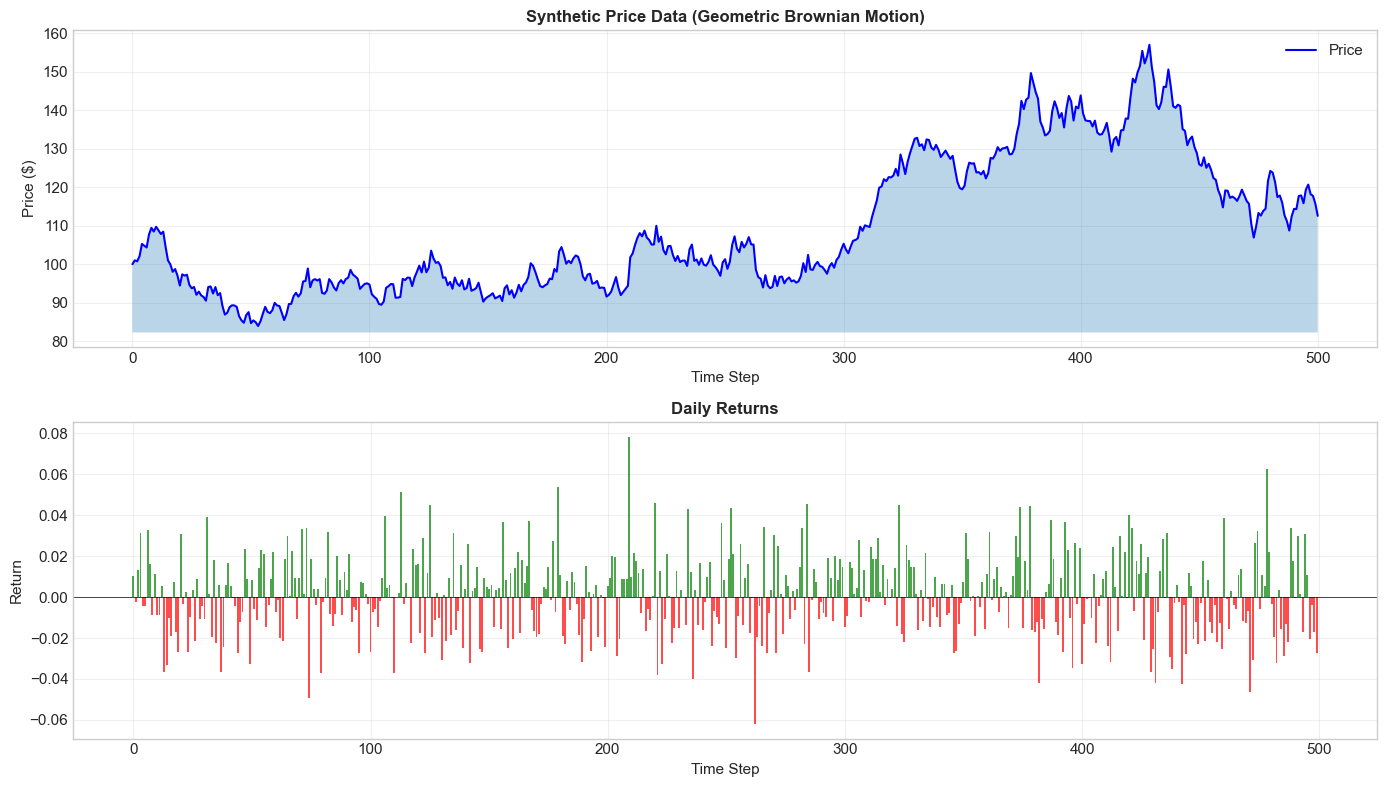


Price Statistics:
  Start: $100.00
  End: $112.57
  Min: $83.94
  Max: $157.01
  Total Return: 12.57%


In [7]:
# Generate Synthetic Price Data

def generate_price_data(n_steps: int = 500, 
                        initial_price: float = 100.0,
                        drift: float = 0.0001,
                        volatility: float = 0.02,
                        seed: int = 42) -> np.ndarray:
    """
    Generate synthetic price data using Geometric Brownian Motion.
    
    dS = μS*dt + σS*dW
    """
    np.random.seed(seed)
    
    # Generate returns
    returns = np.random.normal(drift, volatility, n_steps)
    
    # Add some trending behavior
    trend = np.sin(np.linspace(0, 4*np.pi, n_steps)) * 0.002
    returns = returns + trend
    
    # Convert to prices
    prices = initial_price * np.exp(np.cumsum(returns))
    prices = np.insert(prices, 0, initial_price)
    
    return prices


# Generate and visualize price data
prices = generate_price_data(n_steps=500)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Price plot
ax1 = axes[0]
ax1.plot(prices, 'b-', linewidth=1.5, label='Price')
ax1.fill_between(range(len(prices)), prices.min() * 0.98, prices, alpha=0.3)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Price ($)')
ax1.set_title('Synthetic Price Data (Geometric Brownian Motion)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Returns plot
ax2 = axes[1]
returns = np.diff(prices) / prices[:-1]
ax2.bar(range(len(returns)), returns, color=['green' if r > 0 else 'red' for r in returns], alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Return')
ax2.set_title('Daily Returns', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPrice Statistics:")
print(f"  Start: ${prices[0]:.2f}")
print(f"  End: ${prices[-1]:.2f}")
print(f"  Min: ${prices.min():.2f}")
print(f"  Max: ${prices.max():.2f}")
print(f"  Total Return: {(prices[-1]/prices[0] - 1)*100:.2f}%")

In [8]:
# Test the Trading Environment

# Create environment
env = SimpleTradingEnvironment(prices, lookback_window=10)

print("Environment Properties:")
print(f"  State Dimension: {env.state_dim}")
print(f"  Action Dimension: {env.action_dim}")
print(f"  Total Steps: {len(prices) - env.lookback_window - 1}")
print()

# Reset and get initial state
initial_state = env.reset()
print("Initial State:")
print(f"  Shape: {initial_state.shape}")
print(f"  Values: {initial_state}")
print()

# Take a few example steps
print("Taking Example Steps:")
print("=" * 60)

actions = [2, 1, 1, 0, 1, 2]  # Buy, Hold, Hold, Sell, Hold, Buy
action_names = ['Sell', 'Hold', 'Buy']

for i, action in enumerate(actions):
    state, reward, done, info = env.step(action)
    print(f"\nStep {i+1}: Action = {action_names[action]}")
    print(f"  Reward: {reward:.4f}")
    print(f"  Position: {['Short', 'Flat', 'Long'][info['position'] + 1]}")
    print(f"  Price: ${info['price']:.2f}")
    print(f"  Total P&L: ${info['total_pnl']:.2f}")

Environment Properties:
  State Dimension: 13
  Action Dimension: 3
  Total Steps: 490

Initial State:
  Shape: (13,)
  Values: [ 0.01008479 -0.00261151  0.01324136  0.03118802 -0.00437236 -0.00432221
  0.03250233  0.01592491 -0.00884989  0.01146586  0.          0.
  0.01387735]

Taking Example Steps:

Step 1: Action = Buy
  Reward: 1.1342
  Position: Long
  Price: $109.73
  Total P&L: $0.00

Step 2: Action = Hold
  Reward: -0.9473
  Position: Long
  Price: $108.78
  Total P&L: $0.00

Step 3: Action = Hold
  Reward: -0.9388
  Position: Long
  Price: $107.85
  Total P&L: $0.00

Step 4: Action = Sell
  Reward: -0.7070
  Position: Short
  Price: $108.44
  Total P&L: $-1.29

Step 5: Action = Hold
  Reward: 3.9937
  Position: Short
  Price: $104.45
  Total P&L: $-1.29

Step 6: Action = Buy
  Reward: -3.5631
  Position: Long
  Price: $100.99
  Total P&L: $6.17


In [9]:
# Run a Random Agent Episode

def run_episode(env: SimpleTradingEnvironment, 
                policy: str = 'random',
                verbose: bool = False) -> Dict:
    """
    Run a complete episode with a given policy.
    
    Args:
        env: Trading environment
        policy: 'random', 'always_long', 'always_short', 'trend_following'
        verbose: Print step details
    """
    state = env.reset()
    done = False
    total_reward = 0
    rewards = []
    positions = []
    prices_history = []
    
    while not done:
        # Select action based on policy
        if policy == 'random':
            action = np.random.choice([0, 1, 2])
        elif policy == 'always_long':
            action = 2  # Always buy
        elif policy == 'always_short':
            action = 0  # Always sell
        elif policy == 'trend_following':
            # Simple trend following: look at recent returns
            recent_return = state[:env.lookback_window].mean()
            if recent_return > 0.002:
                action = 2  # Buy on uptrend
            elif recent_return < -0.002:
                action = 0  # Sell on downtrend
            else:
                action = 1  # Hold
        else:
            action = 1  # Default: hold
        
        state, reward, done, info = env.step(action)
        total_reward += reward
        rewards.append(reward)
        positions.append(info['position'])
        prices_history.append(info['price'])
        
        if verbose:
            env.render()
    
    return {
        'total_reward': total_reward,
        'total_pnl': env.total_pnl,
        'total_trades': env.total_trades,
        'rewards': rewards,
        'positions': positions,
        'prices': prices_history
    }


# Compare different policies
policies = ['random', 'always_long', 'always_short', 'trend_following']
results = {}

print("Policy Comparison:")
print("=" * 70)

for policy in policies:
    # Run multiple episodes for random policy
    if policy == 'random':
        episode_results = []
        for _ in range(10):
            res = run_episode(env, policy)
            episode_results.append(res['total_reward'])
        avg_reward = np.mean(episode_results)
        std_reward = np.std(episode_results)
        results[policy] = run_episode(env, policy)
        print(f"\n{policy.upper()}:")
        print(f"  Avg Total Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    else:
        results[policy] = run_episode(env, policy)
        print(f"\n{policy.upper()}:")
        print(f"  Total Reward: {results[policy]['total_reward']:.2f}")
    
    print(f"  Total P&L: ${results[policy]['total_pnl']:.2f}")
    print(f"  Total Trades: {results[policy]['total_trades']}")

Policy Comparison:

RANDOM:
  Avg Total Reward: -24.49 ± 54.43
  Total P&L: $-4.89
  Total Trades: 157

ALWAYS_LONG:
  Total Reward: 7.11
  Total P&L: $0.00
  Total Trades: 1

ALWAYS_SHORT:
  Total Reward: -7.33
  Total P&L: $0.00
  Total Trades: 1

TREND_FOLLOWING:
  Total Reward: 178.04
  Total P&L: $22.88
  Total Trades: 29


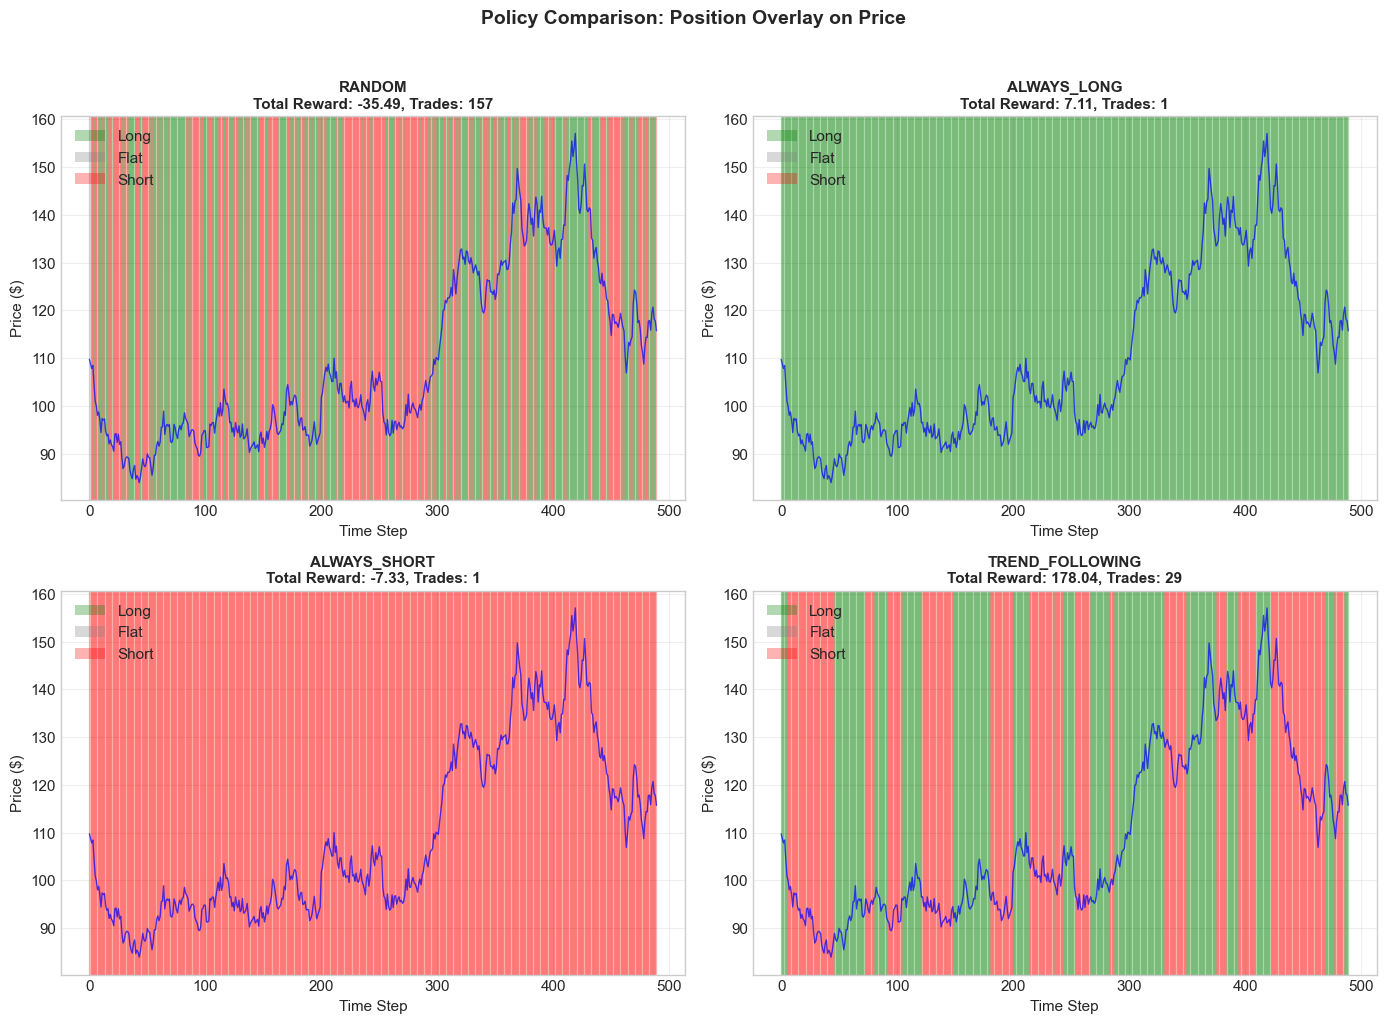

In [10]:
# Visualize Policy Results

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Color maps for positions
position_colors = {-1: 'red', 0: 'gray', 1: 'green'}

for idx, (policy, data) in enumerate(results.items()):
    ax = axes[idx // 2, idx % 2]
    
    prices_plot = data['prices']
    positions = data['positions']
    
    # Plot prices
    ax.plot(prices_plot, 'b-', linewidth=1, alpha=0.7, label='Price')
    
    # Color background based on position
    for i in range(len(positions)-1):
        color = position_colors[positions[i]]
        ax.axvspan(i, i+1, alpha=0.2, color=color)
    
    ax.set_title(f'{policy.upper()}\nTotal Reward: {data["total_reward"]:.2f}, Trades: {data["total_trades"]}',
                fontsize=11, fontweight='bold')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price ($)')
    ax.grid(True, alpha=0.3)
    
    # Add legend for positions
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.3, label='Long'),
        Patch(facecolor='gray', alpha=0.3, label='Flat'),
        Patch(facecolor='red', alpha=0.3, label='Short')
    ]
    ax.legend(handles=legend_elements, loc='upper left')

plt.suptitle('Policy Comparison: Position Overlay on Price', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

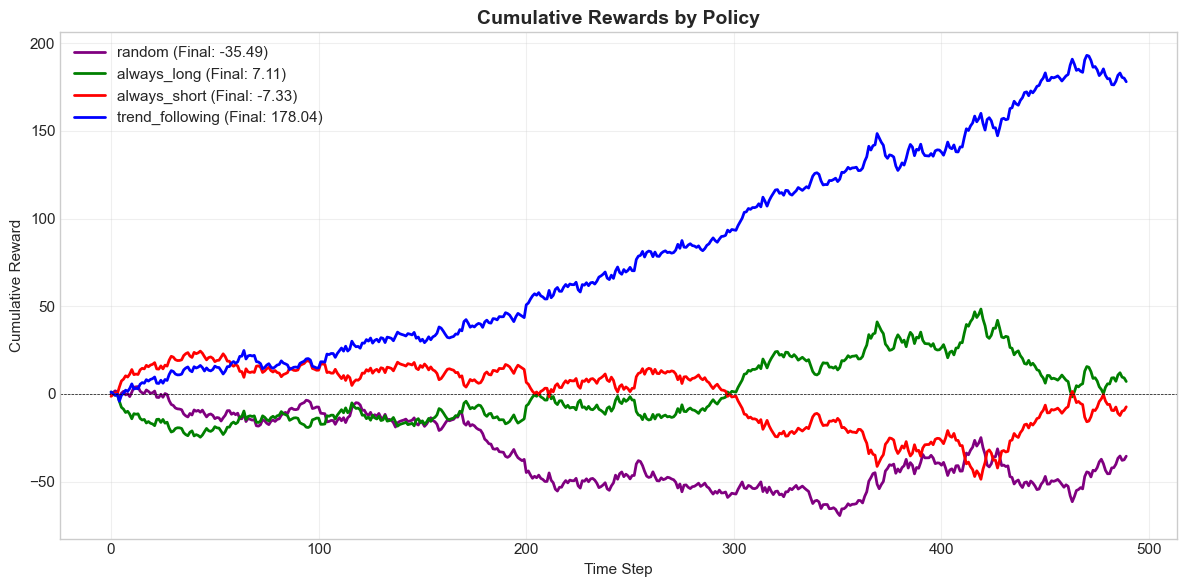

In [11]:
# Cumulative Reward Comparison

fig, ax = plt.subplots(figsize=(12, 6))

colors = {'random': 'purple', 'always_long': 'green', 
          'always_short': 'red', 'trend_following': 'blue'}

for policy, data in results.items():
    cumulative_rewards = np.cumsum(data['rewards'])
    ax.plot(cumulative_rewards, label=f'{policy} (Final: {cumulative_rewards[-1]:.2f})',
           color=colors[policy], linewidth=2)

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax.set_xlabel('Time Step', fontsize=11)
ax.set_ylabel('Cumulative Reward', fontsize=11)
ax.set_title('Cumulative Rewards by Policy', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 5. PyTorch Neural Network for Policy Approximation

In deep RL, we use neural networks to approximate:
- **Policy** $\pi_\theta(a|s)$: maps states to action probabilities
- **Value Function** $V_\theta(s)$ or $Q_\theta(s,a)$: estimates expected returns

Let's build a simple policy network that will be used in future sessions.

In [12]:
class TradingPolicyNetwork(nn.Module):
    """
    Simple feedforward neural network for trading policy.
    Maps state -> action probabilities
    """
    
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 64):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward pass: state -> action probabilities"""
        return self.network(state)
    
    def select_action(self, state: np.ndarray, deterministic: bool = False) -> int:
        """Select action given state"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        
        with torch.no_grad():
            action_probs = self.forward(state_tensor)
        
        if deterministic:
            return action_probs.argmax().item()
        else:
            # Sample from distribution
            dist = torch.distributions.Categorical(action_probs)
            return dist.sample().item()


class TradingValueNetwork(nn.Module):
    """
    Value network for estimating state values V(s).
    Used in actor-critic methods.
    """
    
    def __init__(self, state_dim: int, hidden_dim: int = 64):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, state: torch.Tensor) -> torch.Tensor:
        return self.network(state)


# Create networks
policy_net = TradingPolicyNetwork(state_dim=env.state_dim, action_dim=env.action_dim)
value_net = TradingValueNetwork(state_dim=env.state_dim)

print("Policy Network Architecture:")
print(policy_net)
print(f"\nTotal Parameters: {sum(p.numel() for p in policy_net.parameters()):,}")

print("\n" + "="*60)
print("\nValue Network Architecture:")
print(value_net)
print(f"\nTotal Parameters: {sum(p.numel() for p in value_net.parameters()):,}")

Policy Network Architecture:
TradingPolicyNetwork(
  (network): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=3, bias=True)
    (5): Softmax(dim=-1)
  )
)

Total Parameters: 5,251


Value Network Architecture:
TradingValueNetwork(
  (network): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

Total Parameters: 5,121


In [13]:
# Test the Networks

# Get a sample state from environment
sample_state = env.reset()

print("Network Forward Pass Test:")
print("=" * 50)

# Test policy network
state_tensor = torch.FloatTensor(sample_state).unsqueeze(0)
action_probs = policy_net(state_tensor)
print(f"\nInput State Shape: {sample_state.shape}")
print(f"Action Probabilities: {action_probs.detach().numpy().squeeze()}")
print(f"  P(Sell):  {action_probs[0, 0].item():.3f}")
print(f"  P(Hold):  {action_probs[0, 1].item():.3f}")
print(f"  P(Buy):   {action_probs[0, 2].item():.3f}")

# Test value network
state_value = value_net(state_tensor)
print(f"\nState Value V(s): {state_value.item():.4f}")

# Test action selection
print("\nAction Selection (10 samples with stochastic policy):")
actions = [policy_net.select_action(sample_state) for _ in range(10)]
action_names = ['Sell', 'Hold', 'Buy']
print([action_names[a] for a in actions])

Network Forward Pass Test:

Input State Shape: (13,)
Action Probabilities: [0.33269435 0.33399087 0.33331478]
  P(Sell):  0.333
  P(Hold):  0.334
  P(Buy):   0.333

State Value V(s): 0.0372

Action Selection (10 samples with stochastic policy):
['Sell', 'Hold', 'Hold', 'Hold', 'Buy', 'Sell', 'Hold', 'Sell', 'Hold', 'Sell']


Untrained Neural Network Policy Results:
Total Reward: 8.05
Total P&L: $42.35
Total Trades: 167


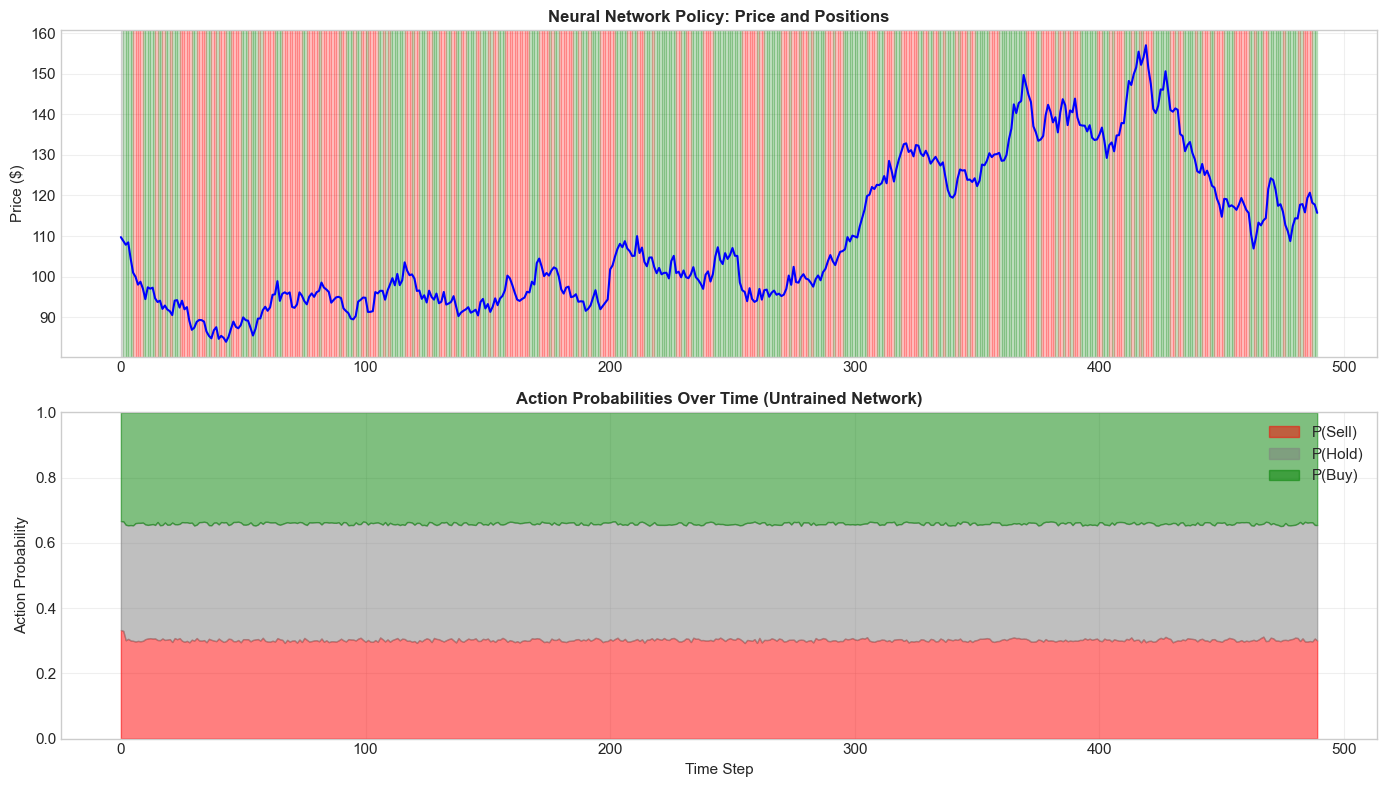

In [14]:
# Run Episode with Neural Network Policy (Untrained)

def run_episode_with_network(env: SimpleTradingEnvironment,
                             policy_net: TradingPolicyNetwork,
                             deterministic: bool = False) -> Dict:
    """Run episode using neural network policy."""
    state = env.reset()
    done = False
    total_reward = 0
    rewards = []
    positions = []
    prices_history = []
    action_probs_history = []
    
    while not done:
        # Get action from network
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_probs = policy_net(state_tensor)
        
        action = policy_net.select_action(state, deterministic=deterministic)
        
        # Take step
        state, reward, done, info = env.step(action)
        
        total_reward += reward
        rewards.append(reward)
        positions.append(info['position'])
        prices_history.append(info['price'])
        action_probs_history.append(action_probs.numpy().squeeze())
    
    return {
        'total_reward': total_reward,
        'total_pnl': env.total_pnl,
        'total_trades': env.total_trades,
        'rewards': rewards,
        'positions': positions,
        'prices': prices_history,
        'action_probs': np.array(action_probs_history)
    }


# Run with untrained network
nn_results = run_episode_with_network(env, policy_net)

print("Untrained Neural Network Policy Results:")
print("=" * 50)
print(f"Total Reward: {nn_results['total_reward']:.2f}")
print(f"Total P&L: ${nn_results['total_pnl']:.2f}")
print(f"Total Trades: {nn_results['total_trades']}")

# Visualize action probability evolution
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Price and positions
ax1 = axes[0]
ax1.plot(nn_results['prices'], 'b-', linewidth=1.5, label='Price')
for i in range(len(nn_results['positions'])-1):
    color = position_colors[nn_results['positions'][i]]
    ax1.axvspan(i, i+1, alpha=0.2, color=color)
ax1.set_ylabel('Price ($)')
ax1.set_title('Neural Network Policy: Price and Positions', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Action probabilities
ax2 = axes[1]
action_probs = nn_results['action_probs']
ax2.fill_between(range(len(action_probs)), 0, action_probs[:, 0], 
                 alpha=0.5, color='red', label='P(Sell)')
ax2.fill_between(range(len(action_probs)), action_probs[:, 0], 
                 action_probs[:, 0] + action_probs[:, 1], 
                 alpha=0.5, color='gray', label='P(Hold)')
ax2.fill_between(range(len(action_probs)), action_probs[:, 0] + action_probs[:, 1], 
                 1, alpha=0.5, color='green', label='P(Buy)')
ax2.set_ylabel('Action Probability')
ax2.set_xlabel('Time Step')
ax2.set_title('Action Probabilities Over Time (Untrained Network)', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Summary & Key Takeaways

### What We Learned Today:

1. **MDP Framework**: Trading naturally fits the $(S, A, P, R, \gamma)$ tuple
   - States encode market and portfolio information
   - Actions are trading decisions (buy/sell/hold)
   - Rewards capture risk-adjusted returns

2. **Component Design**:
   - **State Space**: Must capture all relevant information (Markov property)
   - **Action Space**: Discrete (buy/sell/hold) or continuous (position sizing)
   - **Reward Function**: Critical design choice - simple P&L vs risk-adjusted

3. **Environment Implementation**:
   - OpenAI Gym interface: `reset()`, `step()`, `render()`
   - Handles position tracking, P&L calculation, transaction costs

4. **Neural Network Policies**:
   - Policy network: $\pi_\theta(a|s)$ outputs action probabilities
   - Value network: $V_\theta(s)$ estimates expected returns

### Coming Up Next (Day 2):
- **Q-Learning** fundamentals
- **DQN (Deep Q-Network)** implementation
- Experience replay and target networks

---

## Exercises

1. **State Design**: Add more features to the state (e.g., RSI, MACD). How does this affect the state dimension?

2. **Reward Engineering**: Implement a Sharpe ratio-based reward function. Compare with simple P&L.

3. **Environment Extension**: Add support for continuous position sizing (not just -1, 0, 1).

4. **Multi-Asset**: Extend the environment to handle multiple assets.

In [15]:
# Exercise Solutions Placeholder

# Exercise 1: Enhanced State with Technical Indicators
def calculate_rsi(prices: np.ndarray, period: int = 14) -> float:
    """Calculate RSI indicator"""
    deltas = np.diff(prices)
    gains = np.where(deltas > 0, deltas, 0)
    losses = np.where(deltas < 0, -deltas, 0)
    
    avg_gain = np.mean(gains[-period:])
    avg_loss = np.mean(losses[-period:])
    
    if avg_loss == 0:
        return 100
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


# Exercise 2: Sharpe Ratio Reward
class SharpeReward:
    """Rolling Sharpe ratio-based reward"""
    def __init__(self, window: int = 20):
        self.window = window
        self.returns = []
    
    def calculate(self, current_return: float) -> float:
        self.returns.append(current_return)
        if len(self.returns) < self.window:
            return current_return
        
        recent = self.returns[-self.window:]
        sharpe = np.mean(recent) / (np.std(recent) + 1e-8)
        return sharpe * np.sqrt(252)  # Annualized


print("Exercise solutions available above!")
print("Try extending the SimpleTradingEnvironment class with these features.")

Exercise solutions available above!
Try extending the SimpleTradingEnvironment class with these features.
